In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from bokeh.plotting import figure
from bokeh.io import push_notebook,output_notebook, show
from bokeh.models import LinearAxis, Range1d
from bokeh.models.widgets import Panel
from bokeh.models.widgets import Tabs
output_notebook()

Loading BokehJS ...

In [2]:
df = pd.read_csv('base_energie.csv')
df = df[['Région','Date','Heure','Consommation (MW)','Température (°C)']]
df['année'] = df['Date'].apply(lambda x : int(x[0:4]))

In [3]:
population = pd.read_csv('histo-population.csv', sep=';')
ferie = pd.read_csv('jours-feries.csv', sep=';')
vacances = pd.read_csv('vacances.csv', sep=';')
activeco = pd.read_csv('histo-va-millions-euros.csv', sep=';')

In [4]:
df = pd.merge(df, population, how='left', left_on=['année', 'Région'], right_on=[
              'annee','région'])
df = df.drop(columns=['annee','région'])
df = pd.merge(df, ferie, how='left', left_on='Date', right_on=
              'date')
df = df.drop(columns='date')
df = pd.merge(df, activeco, how='left', left_on=['année', 'Région'], right_on=['année','région'])
df = df.drop(columns='région')
df = pd.merge(df, vacances, how='left', left_on=['Région','Date'],
              right_on=['nom_region','date_jour'])
df = df.drop(columns=['nom_region','date_jour'])
df['nom_jour_ferie'].fillna('non', inplace=True)

**IMPORTANT**

Les données importées ci dessous n'ont pas le meme périmètre d'historicité.
La population et les jours fériés couvrent toute la période.

L'activité économique ne couvre que la période 2013-2018 (pas de données postérieures)

Les vacances par zone ne peuvent s'appliquer aux régions qu'à partir de 2016. Auparavant le zonage des dates de vacances par académie ne permet pas un recoupement avec celui des régions.

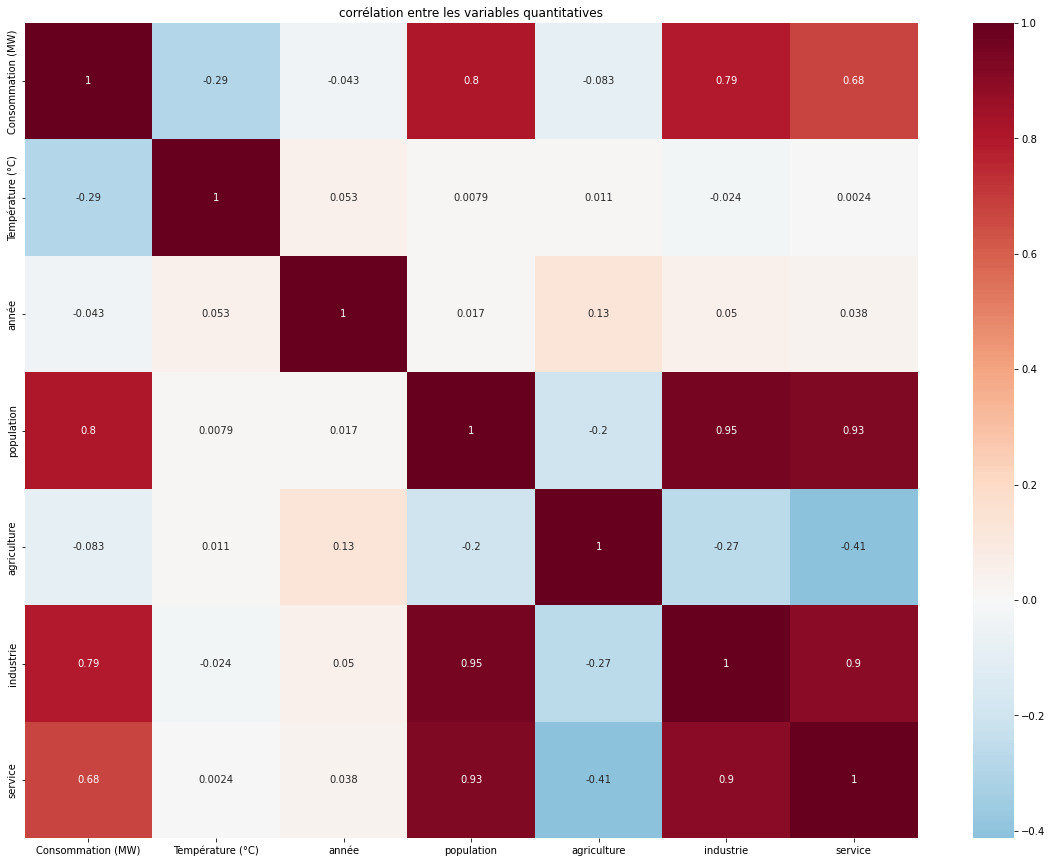

In [5]:
#corrélation des variables quantitatives
plt.figure(figsize=(20,15))
gr1 =sns.heatmap(df.corr(), annot=True, center=0, cmap='RdBu_r')
gr1.set_title("corrélation entre les variables quantitatives");

In [6]:
#validation des p-value pour les variables températures, population, industrie et services qui ont les liens
#de corrélation les plus forts avec la variable cible
#on crée un df dédié qui ne contient pas de nan
dfstat = df[df['année'].isin([2014,2015,2016,2017,2018])]
from scipy.stats import pearsonr
listparam = ['Température (°C)', 'population', 'industrie','service']
for i in listparam :
    test = pearsonr(dfstat['Consommation (MW)'], dfstat[i])
    print (i,' :\n',test)

Température (°C)  :
 (-0.2865315898878216, 0.0)
population  :
 (0.8109684362828676, 0.0)
industrie  :
 (0.7984220788099274, 0.0)
service  :
 (0.676752447494295, 0.0)


In [7]:
repart = df[df['année'] == 2019].groupby('Région').agg({'Consommation (MW)':'mean','population':'mean'})

In [8]:
#création d'un tableau pour comparer la part de la population par rapport à la part d'électricité consommée
#année 2019

In [9]:
repart['part conso %'] = repart['Consommation (MW)'].apply(lambda x : round (x/repart['Consommation (MW)'].sum()*100,1))
repart['part pop %'] = repart['population'].apply(lambda x : round (x/repart['population'].sum()*100,1))
repart['ecart %'] = repart['part conso %'] - repart['part pop %']

In [10]:
repart

,Consommation (MW),population,part conso %,part pop %,ecart %
Région,,,,,
Auvergne-Rhône-Alpes,7475.802854,8042936,13.9,12.4,1.5
Bourgogne-Franche-Comté,2429.592637,2805580,4.5,4.3,0.2
Bretagne,2583.277169,3354854,4.8,5.2,-0.4
Centre-Val de Loire,2154.857135,2573180,4.0,4.0,0.0
Grand Est,5200.075856,5556219,9.7,8.6,1.1
Hauts-de-France,5687.108733,6004947,10.6,9.3,1.3
Normandie,3160.919521,3325032,5.9,5.1,0.8
Nouvelle-Aquitaine,4949.286187,6010289,9.2,9.3,-0.1
Occitanie,4347.741210,5933185,8.1,9.2,-1.1


In [11]:
#courbe conso et température par région
df['mois'] = df['Date'].apply(lambda x : x[5:7])
dfg = df.groupby(['Région','mois'], as_index=False).agg({'Consommation (MW)':'mean','Température (°C)':'mean'})

In [12]:
regions = dfg['Région'].unique()
d = 1
tablist = []
for i in regions :
    fd = figure(y_axis_label='Consommation (MW)', title='Evolution mensuelle des témpératures et consommations moyennes pour la région')
    fd.extra_y_ranges = {"températures": Range1d(start=-10, end=40)}
    fd.xaxis.ticker = [1, 4, 7, 10]
    fd.xaxis.major_label_overrides = {1: 'janvier', 4: 'avril', 7: 'juillet', 10:'octobre'}
    fd.add_layout(LinearAxis(y_range_name="températures", axis_label='témpérature'), 'right')
    fd.line(dfg['mois'][dfg['Région']==i], dfg['Consommation (MW)'][dfg['Région']==i], color='red', legend_label='consommation')
    fd.line(dfg['mois'][dfg['Région']==i], dfg['Température (°C)'][dfg['Région']==i], color='blue', y_range_name="températures", legend_label='température')
    tabd = Panel(child = fd, title = i)
    d = d + 1
    tablist.append(tabd)
tabs = Tabs(tabs = tablist)
show(tabs)

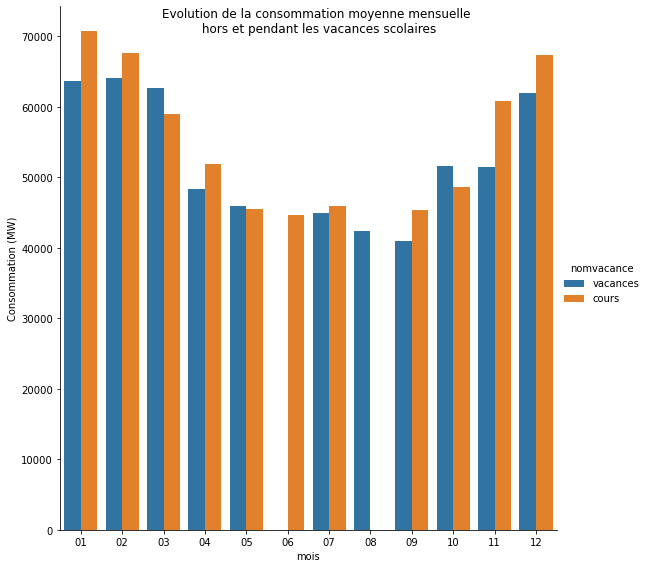

In [13]:
#conso pendant les vacances
dfg = df[df['année'] >= 2016 ].groupby(['Région','mois','nomvacance'], as_index=False).agg({'Consommation (MW)':'mean'})
dfg = dfg.groupby(['mois','nomvacance'], as_index=False).agg({'Consommation (MW)':'sum'})
for i in range(len(dfg)) :
    if dfg['nomvacance'][i] != 'cours' :
        dfg['nomvacance'][i] = 'vacances'
gr2 = sns.catplot(x='mois', y='Consommation (MW)', hue='nomvacance', kind='bar', data=dfg, height=8)
gr2.fig.suptitle("Evolution de la consommation moyenne mensuelle\n hors et pendant les vacances scolaires");

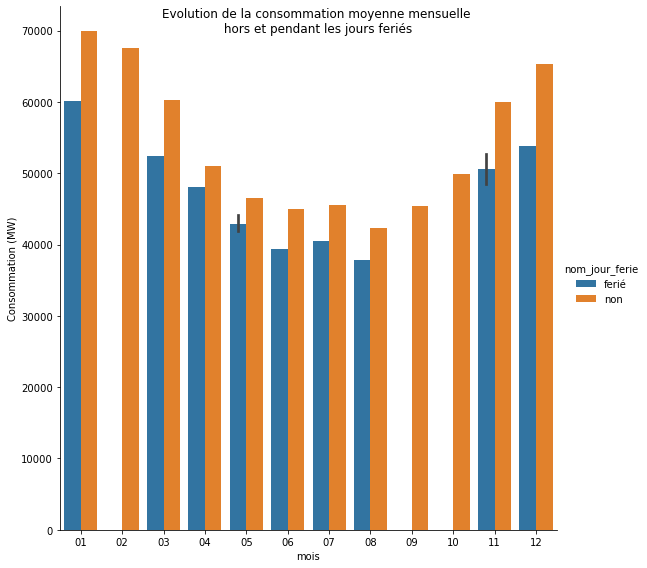

In [14]:
#conso pendant les jours feriés
dfg = df.groupby(['Région','mois','nom_jour_ferie'], as_index=False).agg({'Consommation (MW)':'mean'})
dfg = dfg.groupby(['mois','nom_jour_ferie'], as_index=False).agg({'Consommation (MW)':'sum'})
for i in range(len(dfg)) :
    if dfg['nom_jour_ferie'][i] != 'non' :
        dfg['nom_jour_ferie'][i] = 'ferié'
gr3 = sns.catplot(x='mois', y='Consommation (MW)', hue='nom_jour_ferie', kind='bar', data=dfg, height=8)
gr3.fig.suptitle("Evolution de la consommation moyenne mensuelle\n hors et pendant les jours feriés");